<a href="https://colab.research.google.com/github/Leandro-Braga/Estudo_de_Caso/blob/main/Atividade_ARIMA_Leandeo_Braga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Tema: Projeto Modelagem ARIMA 

O estudo da modelagem autorregressiva integráveis de médias móveis ARIMA, de larga utilização na modelagem de séries estacionárias e não estacionárias integradas, é essencial para o profissional na análise de séries temporais financeiras, econômicas, logísticas, de negócios, gestão, entre outras, pois apresentam características distintas como valores defasados e que ocorrem contemporaneamente e em vários momentos no passado.

A primeira coisa é verificar a estacionariedade nos dados. A estacionaridade será verificada pelo Teste Dicky Fuller Aumentado. A hipótese nula para este teste é que a Série Temporal é não Estacionária. Assim, se o valor de p for menor que 1, rejeitaremos a hipótese nula e acreditaremos que a série é Estacionária.

**Importação das bibliotecas necessárias**

In [ ]:
# biblioteca de análise básica
import pandas as pd
import numpy as np
import seaborn as sns

# biblioteca de modelagem e testes
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm


# bibliotecas de visualização
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import plotly.offline as py
import plotly.graph_objs as go

# ignorando avisos
import warnings
warnings.filterwarnings('ignore')

# Configuração de tamanho, cor e texto
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 16, 6
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['text.color'] = 'G'

print('\033[34mBibliotecas importadas!\033[m')

Bibliotecas importadas!


**Exercício 01**: Geração dos 100 valores diários com início em janeiro de 2021 seguindo a distribuição normal com média 5,0 e variância 1,0. 

In [ ]:
numero = 100
df = pd.DataFrame(dict(Dia=pd.date_range("2021-01-01", 
                                           periods=numero),
                       Valor=np.random.normal(5, 1, numero)))

In [ ]:
df.head(100)

,Dia,Valor
0,2021-01-01,5.223117
1,2021-01-02,5.253683
2,2021-01-03,4.353907
3,2021-01-04,3.208488
4,2021-01-05,4.693870
...,...,...
95,2021-04-06,4.419820
96,2021-04-07,3.741786
97,2021-04-08,5.650324
98,2021-04-09,5.521457


In [ ]:
# Visualizar informação do DataFrame

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Dia     100 non-null    datetime64[ns]
 1   Valor   100 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 KB


Antes de fazer a decomposição da série, temos que transformar a data em índice:

In [ ]:
# Transformando a data em índice

df.Dia = pd.to_datetime(df.Dia)
df.set_index('Dia', inplace=True)

In [ ]:
# Verificando o índice
df.head()

,Valor
Dia,
2021-01-01,5.223117
2021-01-02,5.253683
2021-01-03,4.353907
2021-01-04,3.208488
2021-01-05,4.693870


**Exercício 02**: Exibindo os dados em gráficos para analisar a distribuição.

In [ ]:
# Exibir gráfico de distribuição da série temporal

grafico = [go.Scatter(x=df.index, y=df['Valor'])]
py.iplot(grafico)

#### Identificação

In [ ]:
result = adfuller(df.Valor.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7.739870
p-value: 0.000000


O resultado acima é constante desde que f < 1, caso em que o termo f aproxima-se de zero. Desse modo, o modelo é estacionário, seria não estácionario se e somente se f > 1, portanto confirmando a condição de estacionariedade desse modelo.

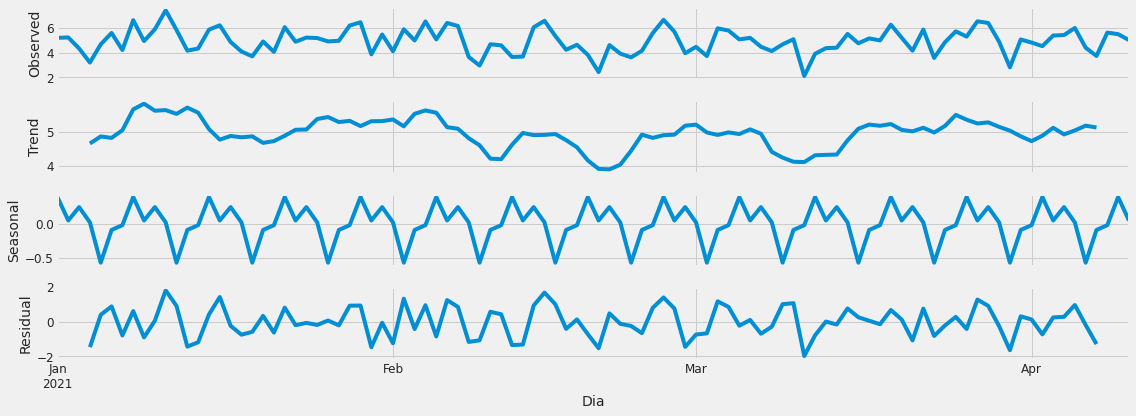

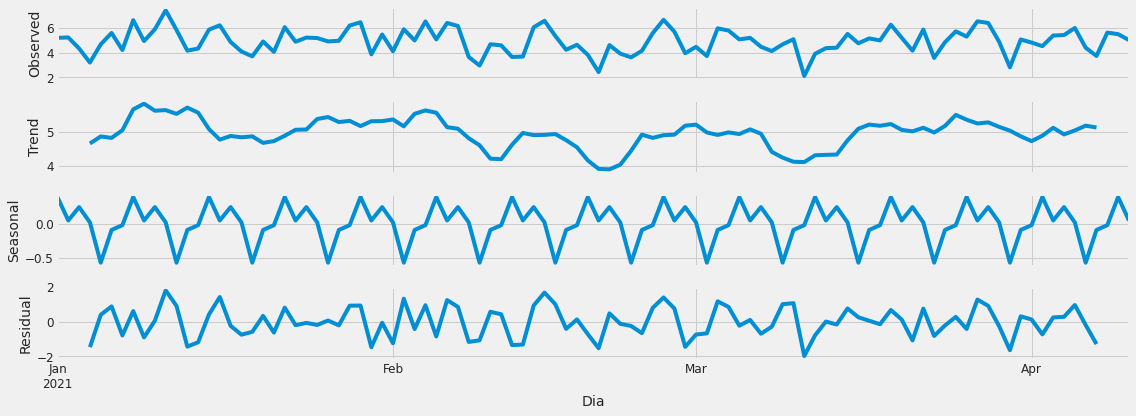

In [ ]:
resultado = seasonal_decompose(df, model='additive')
resultado.plot()

Vamos aplicar a decomposição multiplicativa à série:

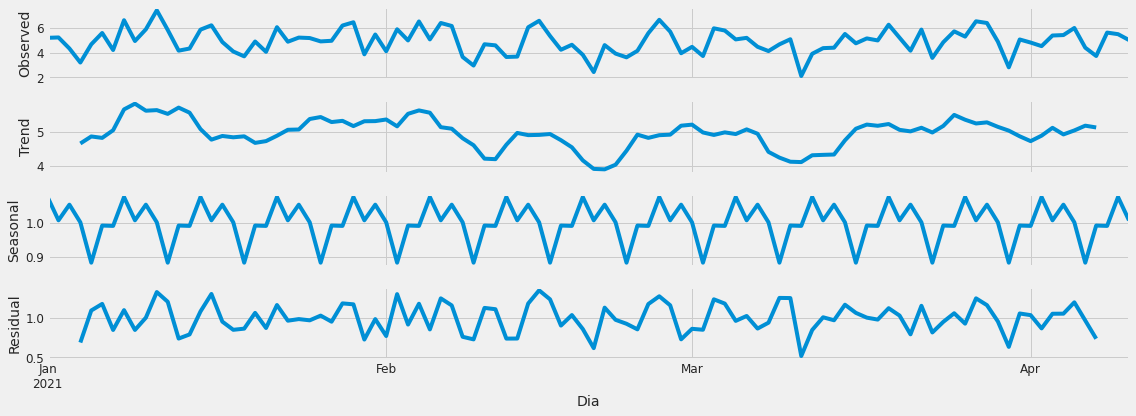

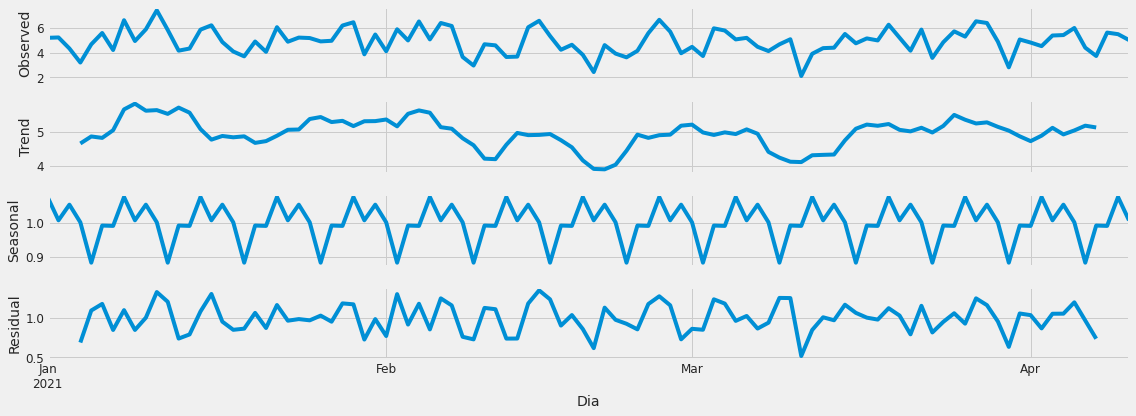

In [ ]:
resultado_M = seasonal_decompose(df, model='multiplicative')
resultado_M.plot()

Observa-se um padrão muito similar entre os modelos de decomposição aditivo e multiplicativo, pois existe pouca ou nenhuma tendência na série. A diferença entre os modelos é maior quando a sazonalidade depende da tendência.

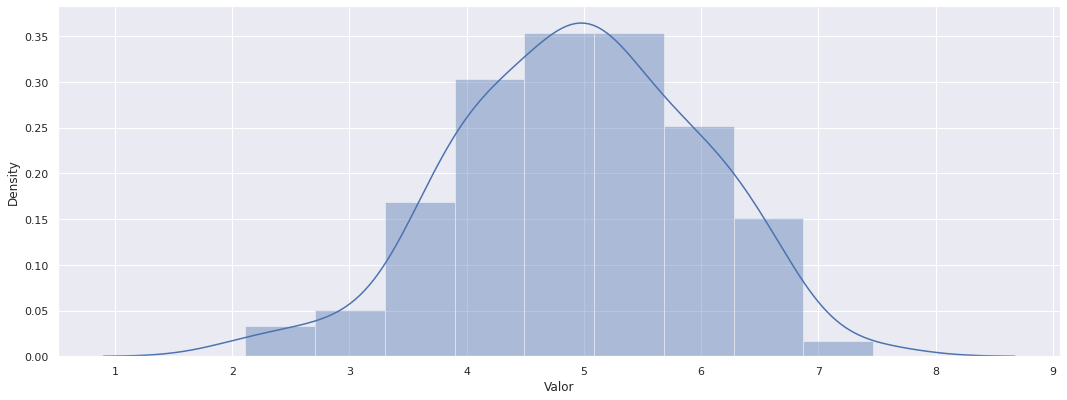

In [ ]:
# Gráfico de histograma da representação aproximada da distribuição dos dados numéricos.

sns.set_theme(style="darkgrid")
sns.distplot(df['Valor'].dropna())

### Modelo de Médias Móveis

Consiste em utilizar como previsão a média simples das observações mais recentes. Consideraremos a média de k valores consecutivos, podemos tomar a média do último período, ou seja, os últimos 4 valores. O pacote Pandas tem funções específicas definidas para determinar médias móveis como pd.DataFrame.rolling. Iremos executar o código com k=4, e o resultado obtido está ilustrado no gráfico a seguir.

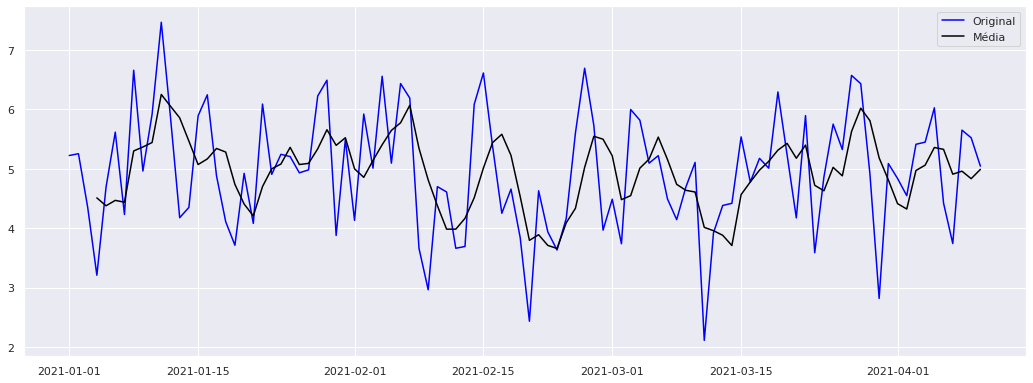

In [ ]:
# Modelo de Médias Móveis comparado a série com k=4

dados = df
mm = pd.DataFrame.rolling(dados,window=4,center=False).mean()
orig = plt.plot(dados, color='blue',label='Original')
mean = plt.plot(mm, color='black',label='Média')
plt.legend(loc='best')
plt.show()

Para realizar das previsões de K passos à frente inicialmente utilizaremos o modelo de médias móveis, para previsão de 10 passos à frente. 

In [ ]:
def moving_average(series, n):
    '''Calcula a média das últimas n observações'''
    return np.average(series[-n:])

In [ ]:
# Previsão 10 passos à frente

moving_average(dados, 10)

5.064844681386935

### Método amortecimento exponencial

Vamos executar o código para Amortecimento Exponencial (sem constante de amortecimento) a seguir:

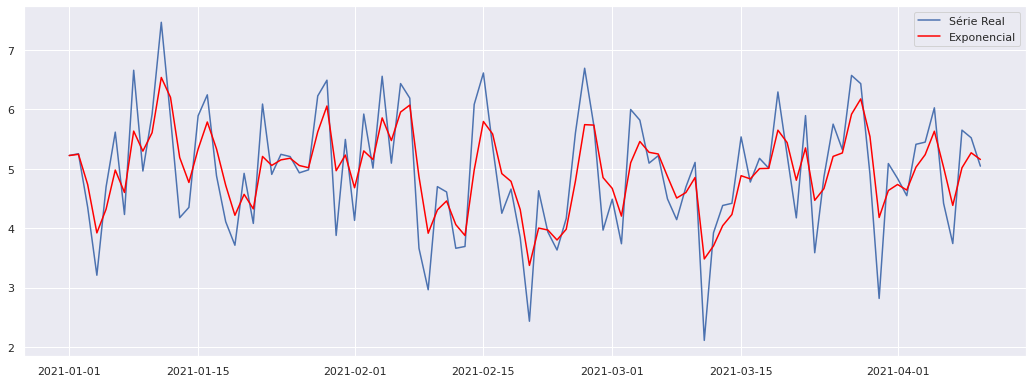

In [ ]:
# Amortecimento Exponencial alfa = 0,5

rolling = dados.ewm(alpha=0.5)
rolling_mean = rolling.mean()
plt.plot(dados, label='Série Real')
plt.plot(rolling_mean, color='red', label='Exponencial')
plt.legend(loc='best')
plt.show()

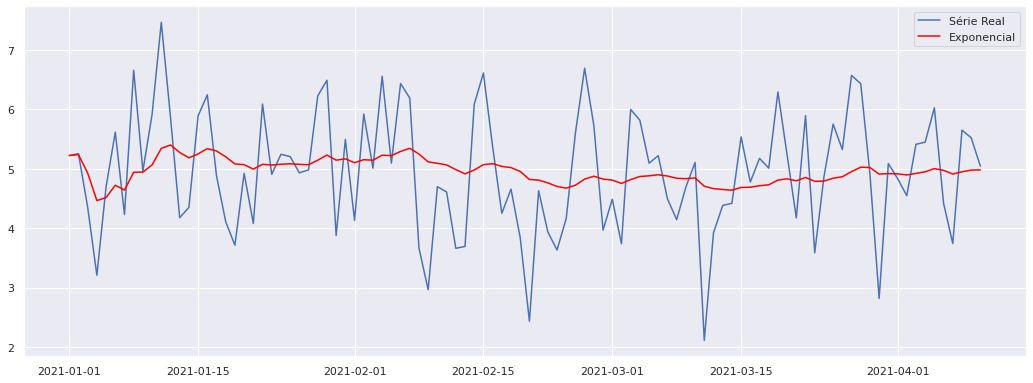

In [ ]:
# Amortecimento Exponencial alfa = 0,05

rolling = dados.ewm(alpha=0.05)
rolling_mean = rolling.mean()
plt.plot(dados, label='Série Real')
plt.plot(rolling_mean, color='red', label='Exponencial')
plt.legend(loc='best')
plt.show()

Gráfico comparando mais de um valor da constante de amortecimento:

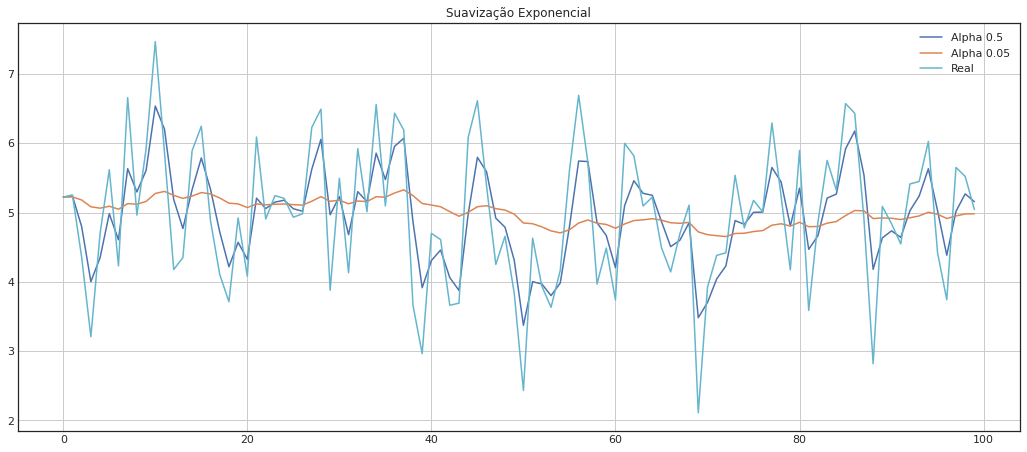

In [ ]:
# Função para comparação com duas constantes de amortecimento:

def exponential_smoothing(series, alpha):
    '''
        séries - dataset com o timestamps

        alpha - com float [0.0, 1.0], e o parametro de suavização

    '''
    result = [series[0]] # o primeiro valor é o mesmo que a série
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    '''
        Plota suavização exponencial com diferentes alfas
        
        séries - dataset com o timestamps

        alphas - uma lista com floats, e parametro de suavização
        
    '''
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(16, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label='Alpha {}'.format(alpha))
        plt.plot(series.values, 'c', label = 'Real')
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title('Suavização Exponencial')
        plt.grid(True)


plotExponentialSmoothing(dados.Valor, [0.5, 0.05])

Gráfico: Comparação com duas constantes de amortecimento.

### Método de Holt Winters

O método de Holt-Winters compreende a equação de previsão e três equações de suavização.

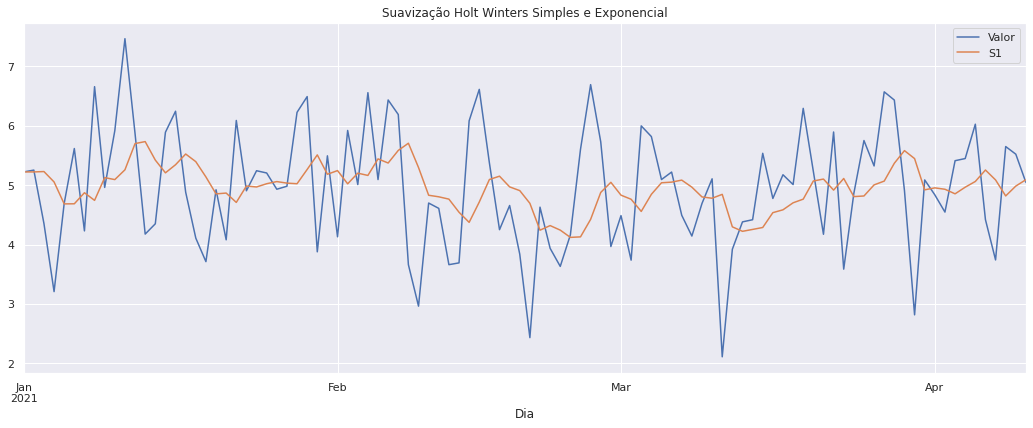

In [ ]:
# holt winters (somente com o nível)

# suavização exponencial simples
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# suavização exponencial dupla e tripla
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Define o valor de Alpha e defina m (Período de Tempo)
alpha = 0.2
df['S1'] = SimpleExpSmoothing(df['Valor']).fit(smoothing_level=alpha,
                                                  optimized=False,
                                                  use_brute=True).fittedvalues

df[['Valor','S1']].plot(title='Suavização Holt Winters Simples e Exponencial')

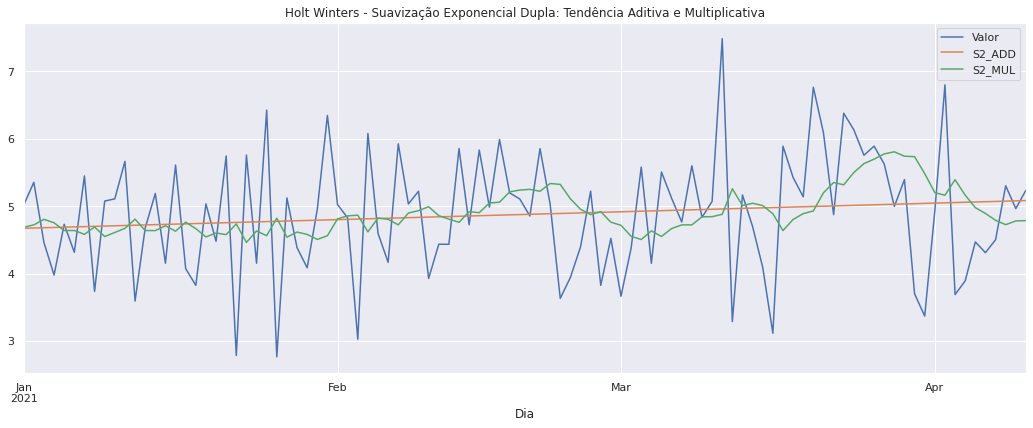

In [72]:
# holt winters (somente com o nível e a tendência aditiva e multiplicativa)

df['S2_ADD'] = ExponentialSmoothing(df['Valor'],trend='add').fit().fittedvalues
df['S2_MUL'] = ExponentialSmoothing(df['Valor'],trend='mul').fit().fittedvalues

df[['Valor','S2_ADD','S2_MUL']].plot(title='Holt Winters - Suavização Exponencial Dupla: Tendência Aditiva e Multiplicativa')

Por último, temos o modelo de Holt-Winters com nível, com a tendência e sazonalidade, tanto para um modelo aditivo quanto multiplicativo:

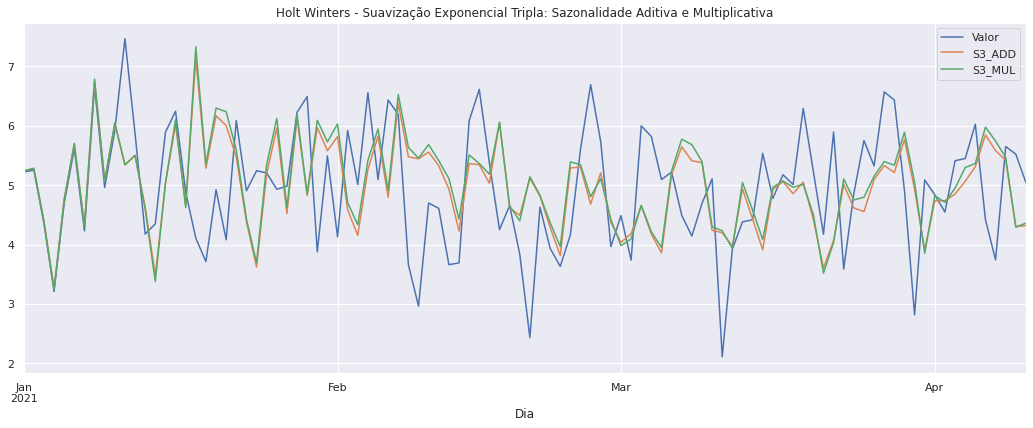

In [ ]:
# holt winters (nível, tendência e sazonalidade, aditiva e multiplicativo)

df['S3_ADD'] = ExponentialSmoothing(df['Valor'],trend='add',seasonal='add',seasonal_periods=10).fit().fittedvalues
df['S3_MUL'] = ExponentialSmoothing(df['Valor'],trend='mul',seasonal='mul',seasonal_periods=10).fit().fittedvalues
df[['Valor','S3_ADD','S3_MUL']].plot(title='Holt Winters - Suavização Exponencial Tripla: Sazonalidade Aditiva e Multiplicativa')

Gráfico: Holt-Winters com nível, tendência e sazonalidade para modelo aditivo e modelo multiplicativo.

Vamos fazer a previsão, utilizando o modelo de Holt-Winters. Começaremos dividindo o conjunto de dados em treino e teste. Pegamos 90 dados como conjunto de treino e os últimos 10 últimos pontos de dados como conjunto de teste:

Text(0.5, 1.0, 'Treinamento, Teste e Previsão usando o Holt Winters Aditivo')

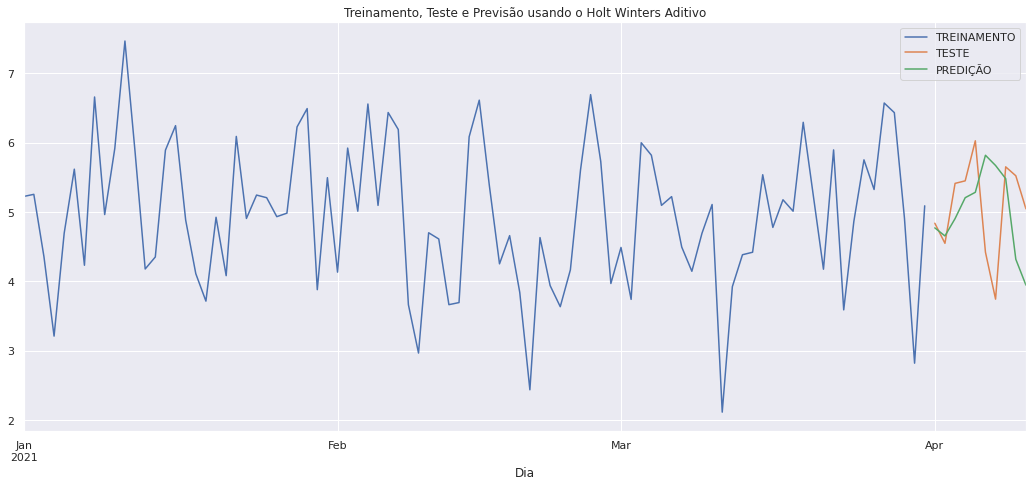

In [ ]:
# Previsão 10 passos a frente com modelo de Holt-Winters

# Divisão do teste e treino
train_df = df[:90]
test_df = df[90:]

# Usando o método de suavização exponencial de tendência aditiva
fitted_model = ExponentialSmoothing(train_df['Valor'],trend='add', 
                                    seasonal='add',
                                    seasonal_periods=10).fit()
# modelo de predição
test_predictions = fitted_model.forecast(10)
train_df['Valor'].plot(legend=True,label='TREINAMENTO')
test_df['Valor'].plot(legend=True,label='TESTE',figsize=(16,7))
test_predictions.plot(legend=True,label='PREDIÇÃO')
plt.title('Treinamento, Teste e Previsão usando o Holt Winters Aditivo')

Text(0.5, 1.0, 'Treinamento, Teste e Previsão usando o Holt Winters Multiplicativo')

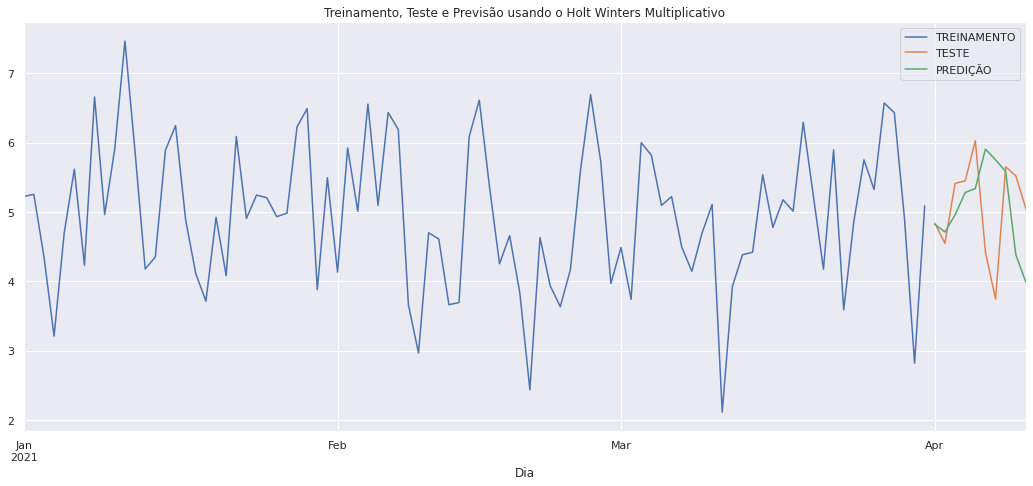

In [ ]:
# Usando o método de suavização exponencial de tendência aditiva

fitted_model = ExponentialSmoothing(train_df['Valor'],trend='mul', 
                                    seasonal='mul',
                                    seasonal_periods=10).fit()
# modelo de predição
test_predictions = fitted_model.forecast(10)
train_df['Valor'].plot(legend=True,label='TREINAMENTO')
test_df['Valor'].plot(legend=True,label='TESTE',figsize=(16,7))
test_predictions.plot(legend=True,label='PREDIÇÃO')
plt.title('Treinamento, Teste e Previsão usando o Holt Winters Multiplicativo')

Gráfico: Previsão 10 passos à frente com modelo de Holt-Winters.

In [ ]:
# 10 Valores previstos Usando o método de suavização exponencial

test_predictions

2021-04-01    4.821767
2021-04-02    4.711085
2021-04-03    4.958359
2021-04-04    5.279975
2021-04-05    5.337751
2021-04-06    5.905731
2021-04-07    5.751866
2021-04-08    5.584004
2021-04-09    4.383842
2021-04-10    3.984633
Freq: D, dtype: float64

Podemos observar que as previsões feitas com o modelo de Holt-Winters se ajustam bem, pois, comparando o período de teste com os valores previstos, vemos que existe o mesmo comportamento na série.

### Modelagem ARIMA 

Utilizaremos a metodologia proposta por Box & Jenkins para a análise da série temporal. A identificação anterior não pretende definir o modelo final para representar a série. Se assim fosse, não haveria necessidade das outras etapas de modelagem. Como já vimos, o objetivo é apenas definir os valores de p, d e q que, inicialmente, sejam adequados para modelar a série, segundo os autores do método, esse diagnóstico costuma conduzir a um modelo subespecificado, menor do que o modelo verdadeiro para a série.

Iremos fazer os gráficos da função de autocorrelação (FAC) e função de autocorrelação parcial (FAC) para confirmar se a série é estacionária.

In [ ]:
# Exibindo os principais dados

df.head()

,Valor,S1,S2_ADD,S2_MUL,S3_ADD,S3_MUL
Dia,,,,,,
2021-01-01,5.223117,5.223117,4.95212,5.056677,5.238156,5.238582
2021-01-02,5.253683,5.223117,4.95212,5.054547,5.282927,5.283976
2021-01-03,4.353907,5.229230,4.95212,5.052417,4.396527,4.390546
2021-01-04,3.208488,5.054166,4.95212,5.050289,3.263664,3.243490
2021-01-05,4.693870,4.685030,4.95212,5.048162,4.760786,4.756056


In [ ]:
df_novo = df.drop(columns=['S1','S2_ADD','S2_MUL','S3_ADD','S3_MUL'])
df_novo.head()

,Valor
Dia,
2021-01-01,5.223117
2021-01-02,5.253683
2021-01-03,4.353907
2021-01-04,3.208488
2021-01-05,4.693870


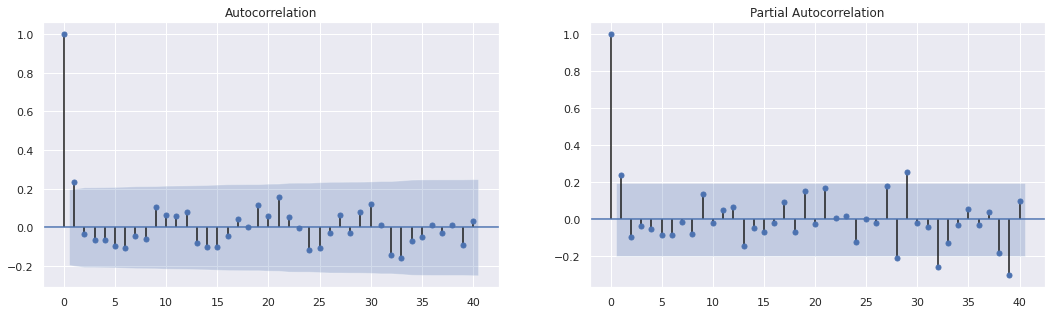

In [ ]:
# Função de autocorrelação (FAC) e função de autocorrelação parcial (FAC)

def acf_pacf(x):
  
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=40, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=40, ax=ax2)

acf_pacf(df_novo)

Observa-se que a FAC (Função de Autocorrelação) decai exponencialmente como senoides amortecidas e a FACP (Função de Autocorrelação Parcial) possui o lag 1 significativo, ou seja, truncada no lag 1, o que sugere um modelo de médias móveis de ordem 1.

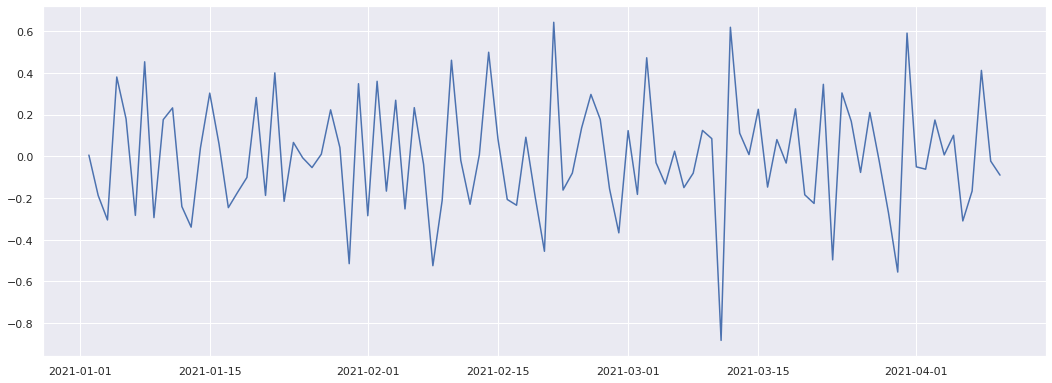

In [ ]:
# Transformar a série em uma série estacionária

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
ax.plot(np.log(df_novo).diff().dropna())

Dessa maneira, o procedimento sugerido por Box & Jenkins para a identificação das ordens p e q de um modelo de séries temporais é, a partir da série que se quer analisar, estimar a FAC obtendo o gráfico da FAC e da FACP amostral.

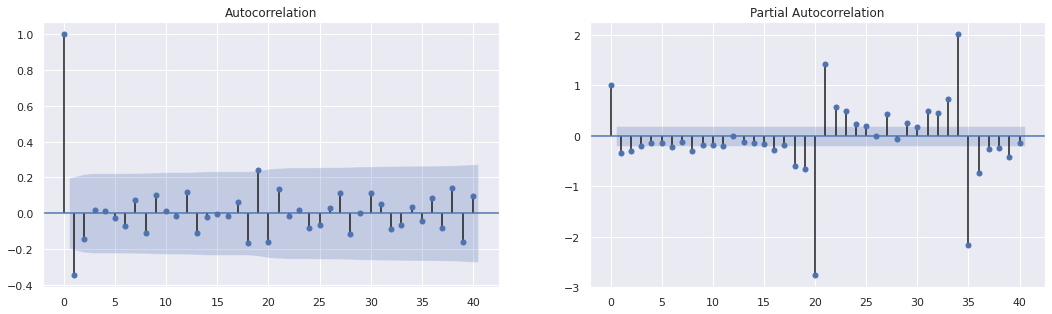

In [ ]:
# FAC e FACP para série estacionária

acf_pacf(np.log(df_novo).diff().dropna())

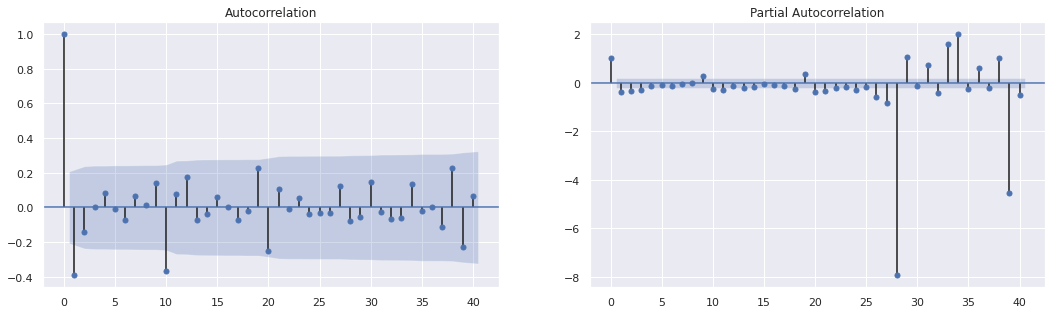

In [ ]:
# FAC e FACP para série estacionária

acf_pacf(np.log(df_novo).diff().diff(10).dropna())

Gráfico: FAC e FACP para série estacionária.

A série transformada, após uma diferença, ou seja, foi identificado que d=1 e aplicada à função logarítmica ficou não estacionária. E como a condição para estimar o modelo ARIMA é que a série não seja estacionária, podemos seguir com a análise:

Observamos que, mesmo após a diferença, a série apresenta os pontos fora do intervalo de confiança; esses pontos estão ocorrendo a cada lag múltiplo de 10, o que caracteriza que necessita de diferença sazonais.

Estimaremos um modelo ARIMA(p,d,q) conforme enunciado do Exercício 04, para prever 10 valores posteriores a n, e em seguida exibir um gráfico Real x Estimado.

Primeiro dividiremos os dados para teste e treinamento:

In [ ]:
# Dividindo os dados para treinamento e teste

df_treinamento, dados_teste = df_novo[0:int(len(df_novo)*0.7)], df_novo[int(len(df_novo)*0.7):]
df_treinamento = df_treinamento['Valor'].values
dados_teste = dados_teste['Valor'].values
df_historico = [x for x in df_treinamento]
modelo_pred = []

In [ ]:
obs_teste = len(dados_teste)

for p_teste in range(obs_teste ):
  modelo = ARIMA(df_historico, order=(1,1,1))
  modelo_fit = modelo.fit(disp=0)
  saida = modelo_fit.forecast()
  yt = saida[0]
  modelo_pred.append(yt)
  valor_R_teste = dados_teste[p_teste]
  df_historico.append(valor_R_teste)

In [ ]:
# Visualização do modelo

modelo_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   98
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -139.855
Method:                       css-mle   S.D. of innovations              0.987
Date:                Mon, 31 Jan 2022   AIC                            287.709
Time:                        00:54:57   BIC                            298.049
Sample:                             1   HQIC                           291.891
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.005     -0.432      0.666      -0.011       0.007
ar.L1.D.y      0.2445      0.099      2.477      0.015       0.051       0.438
ma.L1.D.y     -1.0000      0.031    -32.104      0.000      -1.061      -0.939
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.0903           +0.0000j            4.0903            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
# Geração validação pelo erro quadrático médio

erroMSE = mean_squared_error(dados_teste, modelo_pred)
print(f'O Erro Médio Quadrático (MSE) é {erroMSE}')

O Erro Médio Quadrático (MSE) é 0.8192463300190046


Em estatística, o erro quadrático médio ou desvio quadrático médio de um estimador mede a média dos quadrados dos erros, ou seja, a diferença quadrática média entre os valores estimados e o valor real.

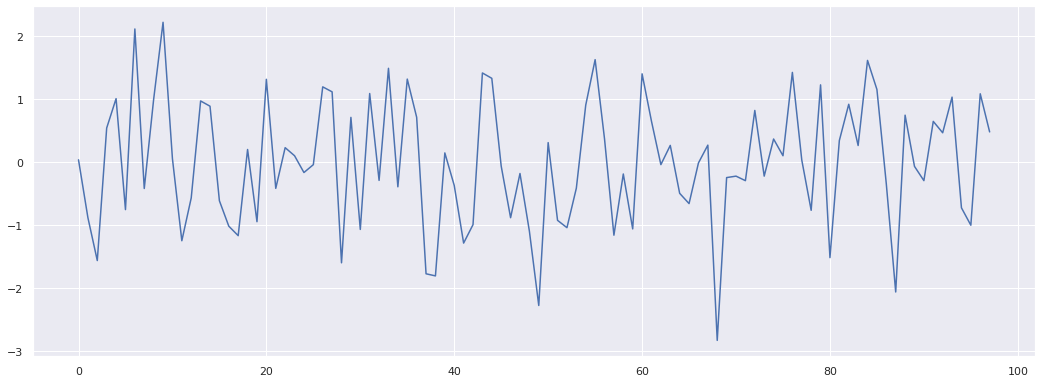

In [ ]:
# Gráfico dos resíduos

grafico_resid = modelo_fit.resid
orig = plt.plot(grafico_resid)
plt.show()

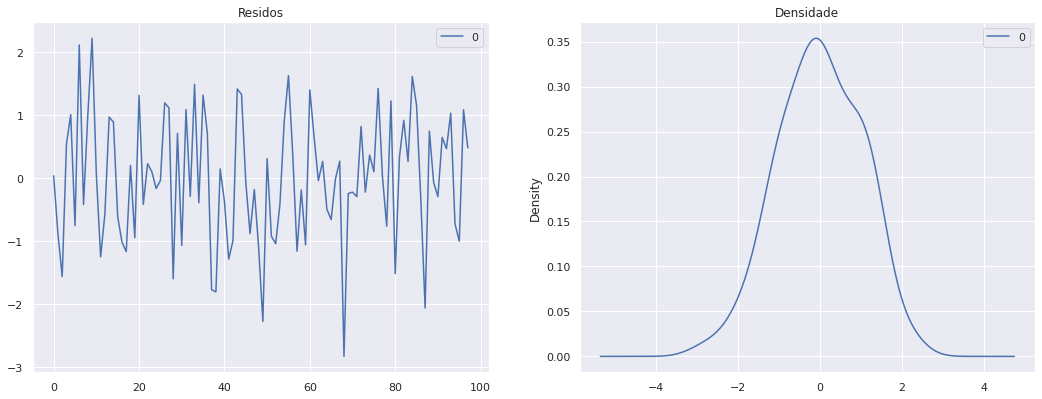

In [ ]:
residuals = pd.DataFrame(grafico_resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residos", ax=ax[0])
residuals.plot(kind='kde', title='Densidade', ax=ax[1])
plt.show()

Gráfico: Resíduos.

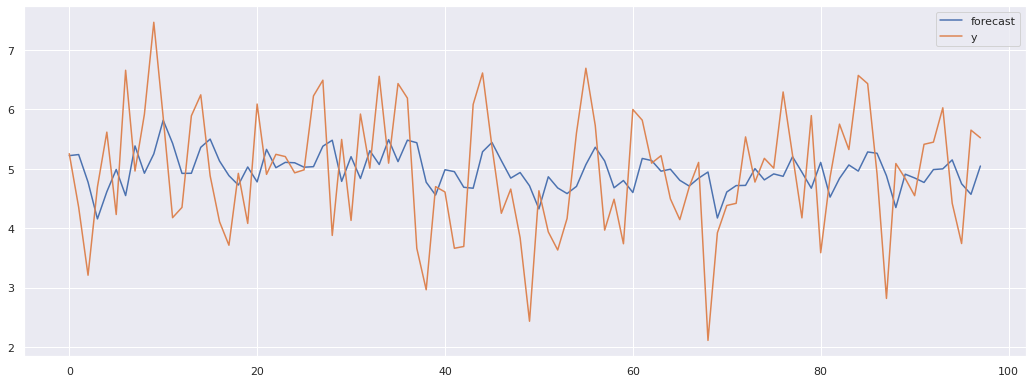

In [ ]:
# Vamos verificar a previsão e também a precisão do modelo

modelo_fit.plot_predict(dynamic=False)
plt.show()

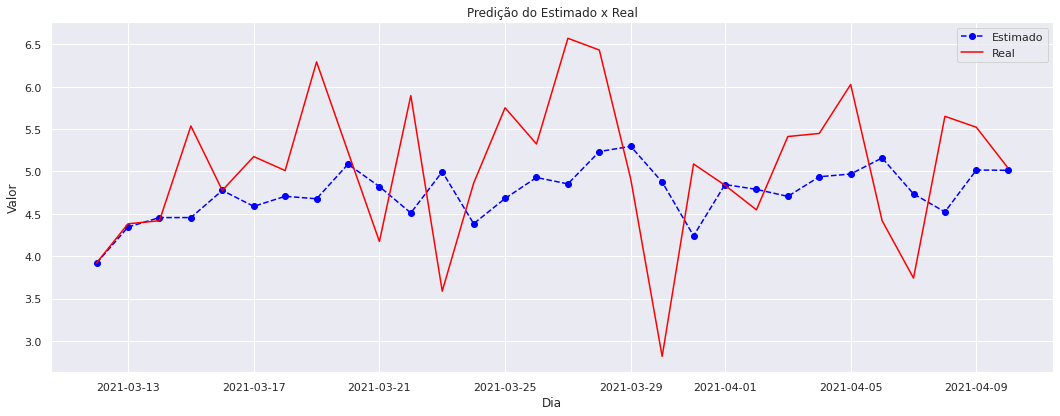

In [ ]:
novo_teste = df_novo[int(len(df_novo)*0.7):].index
# novo_teste = modelo_fit.

plt.plot(novo_teste, 
         modelo_pred, 
         color='blue',
         marker='o',
         linestyle='dashed',
         label='Estimado')

plt.plot(novo_teste, 
         dados_teste, 
         color='red', 
         label='Real')

plt.title('Predição do Estimado x Real')
plt.xlabel('Dia')
plt.ylabel('Valor')
plt.legend()
plt.show()

Gráficos: Previsão - Real x Estimado.

In [ ]:
# Modelo ARIMA 2 para conparação de precisão

modelo = sm.tsa.ARIMA(df_historico, order=(1, 1, 1))  
fitted = modelo.fit(disp=-1)

# Forecast
fc, se, conf = fitted.forecast(1, alpha=0.05)

# MAPE - Mean Absolute Percentage Error
mape = np.mean(np.abs(fc - df_historico)/np.abs(df_historico))

print(f'Valor previsto:{fc}')

Valor previsto:[4.90055308]


O valor previsto pelo modelo final ARIMA foi 4.90055308.

Os resultados são satisfatórios, mas é bom ter uma ideia de como o ARIMA funciona. Vamos fazer uma verificação rápida da métrica de precisão no mesmo para ver o quão bem o modelo pode prever o valor futuro.

In [ ]:
mape

0.18043736948729738

O MAPE é de 0.18043736948729738, ou seja, a precisão do modelo é de 99,81%. O Mean Absolute Percentage Error (MAPE) - erro percentual médio absoluto é um dos KPIs mais usados para medir a precisão da previsão.